# Import new AND old datasets

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import datetime

In [815]:
df_old = pd.read_csv('penn_hr_data.csv')

df = pd.read_csv('clean_data.csv')

df_month = pd.read_csv('penn_hr_monthly.csv')

# More data cleaning

In [324]:
# All columns in clean_data
for i in df.columns.sort_values():
    print(i)

AGE_AT_TERMINATION
Birth_Date
COUNTRY_OF_CITIZENSHIP
Career_Salary_Growth
EDUCATION_LEVEL
EDUCATION_LEVEL_YEAR
EMPLOYMENT_STATUS
GRANT_PAID_F
GRANT_PAID_N
GRANT_PAID_P
HOME_CITY
HOME_DEPT_ORG
HOME_SCHOOL_CTR
IN_UNION
JOBS_ACTIVE
JOB_GRADE
JOB_TITLE
MARITAL_STATUS_D
MARITAL_STATUS_M
MARITAL_STATUS_S
MARITAL_STATUS_W
MONTHS_IN_PRIMARY_JOB
Manager_Age_At_Termination
Manager_Edu_Level
Manager_Edu_Level_Year
Manager_Job_Title
Manager_Months_Managed
Manager_OfColor
Manager_Race_A
Manager_Race_B
Manager_Race_C
Manager_Race_P
Manager_Race_R
Manager_Race_S
Manager_Race_U
Manager_Race_Z
Manager_Sex
Manager_YEARS_OF_SERVICE
Number_of_Reclass
Number_of_Sal_Adjustments
ORIGINAL_HIRE_DATE
PAY_CYCLE
PRIMARY_APPT_BEGIN_DATE
PRIMARY_APPT_SALARY
Percent_Career_Salary_Growth
RACE_A
RACE_B
RACE_C
RACE_P
RACE_R
RACE_S
RACE_U
RACE_Z
Race_OfColor
SEPARATION_REASON
SEX
TERMINATION_DATE
VISA
VISA_EXPIRATION_DATE
VOLUNTARY
Worker_ID
avg_rating


In [182]:
# All columns in monthly snapshot data
for i in df_month.columns.sort_values():
    print(i)

APPT_BEGIN_DATE
Age
BIRTH_DATE
CALENDAR_MONTH
CALENDAR_YEAR
CITY
Calendar_Month
Calendar_Year
Dept_Name
EDUCATION_LEVEL
EMPLOYMENT_STATUS
Education_LEVEL_DESC
FISCAL_MONTH
FISCAL_YEAR
FULL_PART_TIME
HOME_DEPT_ORG
JOB_GRADE
JOB_TITLE
MARITAL_STATUS
Months_In_Job
Months_Of_Service
ORIGINAL_HIRE_DATE
PAY_CYCLE
PRIMARY_APPT_JOB_CLASS
PRIMARY_APPT_SALARY
Race_Desc
SEPARATION_REASON
SEPERATION_REASON_DESC
School_Name
Sex_Desc
TERMINATION_DATE
WORKER_ID
Years_In_Job
Years_Of_Service
ZIP


### Drop certain columns

In [816]:
# Omit current age -- This is calculated based on Sep, 2019; does not mean much
df = df.drop(columns = ['CURRENT_AGE', 'Manager_Current_Age'])

# Omit starting full-time salary (= primary salary - salary increase; collinear)
df = df.drop(columns = ['Starting_Full_Time_Salary'])

### Drop certain entries

In [817]:
# Omit 15 entries that are on leave of absence.
df = df[df['EMPLOYMENT_STATUS'] != 'L']

# Omit 1 entry with invalid visa (19)
# (already dropped)

# Omit entries with negative months of service
df = df[df['MONTHS_IN_PRIMARY_JOB'] >= 0]

# Omit entries with nonsensical education level year
df = df[~df['EDUCATION_LEVEL_YEAR'].isin([1887, 2020, 2105])]

# Omit entries without salary values
df = df[-df['PRIMARY_APPT_SALARY'].isnull()]

### One hot encoding

In [818]:
# Convert T => 1 and A => 0
le = LabelEncoder()

df['EMPLOYMENT_STATUS'] = le.fit_transform(df['EMPLOYMENT_STATUS'])

In [819]:
# Turn "country of citizenship" into a binary column
# US => 0 vs. Other => 1
df.loc[df.COUNTRY_OF_CITIZENSHIP.isnull(), 'COUNTRY_OF_CITIZENSHIP'] = 0
df.loc[~df.COUNTRY_OF_CITIZENSHIP.isnull(), 'COUNTRY_OF_CITIZENSHIP'] = 1

### Monthly dataset

In [ ]:
''' Our main dataset spans July 1, 2009 - June 30, 2019. '''

#### Dropping columns

In [820]:
# Everyone is full-time
df_month = df_month.drop(columns = ['FULL_PART_TIME'])   

#### Dropping entries

In [ ]:
# Comparing monthly dataset to original dataset
df_old.Worker_ID[-df_old.Worker_ID.isin(df_month.WORKER_ID)].value_counts()  
df_month.WORKER_ID[-df_month.WORKER_ID.isin(df_old.Worker_ID)].value_counts()

# There are 5346 workers in original dataset that are NOT in the monthly dataset.
# There are 14 workers in the monthly dataset that are NOT in the original dataset.

In [822]:
# Drop workers that are not in the original dataset.
df_month = df_month[df_month.WORKER_ID.isin(df.Worker_ID)]

# Keep only employment status == A or T
df_month = df_month[df_month.EMPLOYMENT_STATUS.isin(['A', 'T'])]

#### Create headcount df

In [823]:
''' Separate bad vs. good hires '''
# Subset 'employees Penn should refrain from hiring'
df_month_bad = df_month[df_month['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24'])]

# Subset 'employees that Penn can do things for do keep' (i.e. excludes 'out of control' reasons)
df_month_good = df_month[-df_month['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24', '3', '4', '6', '30', '31', '80', '81'])]

In [824]:
# Focus analysis on "good" hires

# df for active employees
df_headcount_A = df_month_good[df_month_good.EMPLOYMENT_STATUS == 'A'].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
df_A_unstack = df_headcount_A.unstack()
df_A_unstack = df_A_unstack.fillna(0)

# df for terminated employees
df_headcount_T = df_month_good[df_month_good.EMPLOYMENT_STATUS == 'T'].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
df_T_unstack = df_headcount_T.unstack()
df_T_unstack = df_T_unstack.fillna(0)

In [ ]:
''' To access each column '''
df_A_unstack.xs(2, level = 'CALENDAR_MONTH', axis = 1)

''' To acces each row '''
df_A_unstack.loc[2008, :]

''' To access a specific entry '''
df_T_unstack.loc[2008, ('WORKER_ID', 1)]

#### Calculate monthly turnover rate

In [825]:
# Vectorize no. of terminated employees
terminated = []

for year in range(2008, 2020):
    for month in range(1, 13):
        terminated.append(df_T_unstack.loc[year, ('WORKER_ID', month)])
        
terminated = terminated[6:-6]

In [826]:
# Vectorize no. of current employees
headcount = []

for year in range(2008, 2020):
    for month in range(1, 13):
        headcount.append(df_A_unstack.loc[year, ('WORKER_ID', month)])
        
headcount = headcount[5:-6]   # include one extra space to take avg(previous & current month)
headcount[0] = headcount[1]   # since the first month is unknown, let it equal July, 2008 count

In [827]:
# Find the avg no. of headcount per month
def avg(prev, current):
    return((prev + current)/2)

avg_employed = []
for i in range(0, len(headcount)-1):
    avg_count = avg(headcount[i], headcount[i+1])
    
    avg_employed.append(avg_count)

In [828]:
# Calculate the monthly turnover
turnover = [(a/b)*100 for a,b in zip(terminated, avg_employed)]

In [829]:
# Create a df of these values, and export as csv.
df_ts = pd.DataFrame(columns = ['Terminated', 'Employed', 'Turnover'])

df_ts['Terminated'] = terminated
df_ts['Employed'] = headcount[1:]
df_ts['Turnover'] = turnover

df_ts.to_csv('Penn_HR_ts.csv')

# Feature engineering

In [ ]:
'''
Keep in mind: Your target variable is EMPLOYMENT_STATUS.

1 = terminated
0 = active
'''

### Time till visa expires

In [ ]:
# Calculate the no. of months till visa expires.
'''
Non foreigners & immigrants don't have a visa expiration date.
This means that they will be in America permanently. To differentiate them from visa-holders, assign them a value = 180.

Why 180? The longest visa is 10 years, so 15 years (= 180 months) is long enough to denote residents as permanent.
'''

''' !!!!!!!  Ask Bret: If not all immigrants are green card holders, they should NOT receive 180 for this feature. '''

In [830]:
# Get today's datetime.
today = datetime.datetime.today()

visa_month = df['VISA_EXPIRATION_DATE'].apply(lambda x: str(x).split('/')[0])
visa_year = df['VISA_EXPIRATION_DATE'].apply(lambda x: str(x)[-9:-5]) 

visa_month = visa_month.replace('nan', 99)
visa_year = visa_year.replace('', 9999)

visa_month = visa_month.apply(lambda x: int(x))
visa_year = visa_year.apply(lambda x: int(x))


# Calculate the no. of months till visa expires.
time_left = (visa_year - today.year) * 12 + (visa_month - today.month)


# Add as a column to the df.
df['VISA_MONTHS_LEFT'] = time_left

In [831]:
# Assign 180 to all workers who don't need to worry about visas.
df.loc[df['VISA'].isin(['IM', '  ']), 'VISA_MONTHS_LEFT'] = 180

### Age when employee started working at Penn

In [832]:
# Put date columns in datetime format again to turn them into numbers (currently strings).
date_cols = ['Birth_Date', 'PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE', 'TERMINATION_DATE']
for col in date_cols:
    df[col] = pd.DatetimeIndex(df[col])


df['AGE_START'] = df['ORIGINAL_HIRE_DATE'] - df['Birth_Date']
df['AGE_START'] = df['AGE_START'].apply(lambda x: int(np.floor(x.days/365)))

### Age when employee last worked at Penn

In [833]:
# For active employees, calculate their age today.
today = datetime.datetime.today()

age_today = today - df['Birth_Date']
age_today = age_today.apply(lambda x: x.days)   # access just the "days" from the calculation results
age_today = np.floor(age_today / 365)

df['AGE_LAST'] = df['AGE_AT_TERMINATION'].fillna(age_today)

### Employee edu > manager edu level

In [390]:
# Dictionary for education levels
edu_dict = dict(zip(df_old['EDUCATION_LEVEL_DESC'].apply(lambda x: str(x)), df_old['EDUCATION_LEVEL']))

for key in sorted(edu_dict.keys()):
    print(key, ': ', edu_dict[key])

Associate Degree :  F 
Bachelor's Degree :  G 
Doctor of Philosophy (Ph.D.) :  K 
High School diploma or equivalent :  C 
Master's Degree :  H 
Medical Doctorate (M.D., D.D.S., D.V.M., V.M.D.) :  I 
No academic credentials :  B 
Other :  L 
Other doctorate (Dr of Educ., Dr of Sct., LL.D.) :  J 
Some college :  E 
Trade certificate :  D 
nan :    


In [ ]:
'''
Education level ranking: 
No academic < HS = nan < some college = trade < Associate < BA < MA < Doctorate (PhD, MD, JD, other)

# Source considered in ranking:
https://www.bls.gov/careeroutlook/2018/article/postsecondary-outlook.htm
'''

In [ ]:
# Map categorical values onto numeric values for employee & manager education levels
replace_map = {'EDUCATION_LEVEL': {'B': 1, 'C': 2, 'E': 3, 'D': 3, 'F': 4, 'G': 5, 'H': 6, 
                                   'K': 7, 'I': 7, 'L': 7, 'J': 7}}

edu_numeric = df.replace(replace_map, inplace = False)   # saves the whole df copy
edu_numeric = edu_numeric['EDUCATION_LEVEL'].fillna(2)   # converts edu_numeric from df into vector

df['EDU_EMPLOYEE'] = edu_numeric


# Repeat mapping for manager education level
replace_map = {'Manager_Edu_Level': {'B': 1, 'C': 2, 'E': 3, 'D': 3, 'F': 4, 'G': 5, 'H': 6, 
                                   'K': 7, 'I': 7, 'L': 7, 'J': 7}}

m_edu_numeric = df.replace(replace_map, inplace = False)   # saves the whole df copy
m_edu_numeric = m_edu_numeric['Manager_Edu_Level'].fillna(2)   # converts edu_numeric from df into vector

df['EDU_MANAGER'] = m_edu_numeric

In [851]:
# Compare employee vs. manager levels. If employee level > manager level, assign 1 for a dummy.
df['EDU_DIFF'] = df['EDU_EMPLOYEE'] - df['EDU_MANAGER']

for index, difference in enumerate(df.EDU_DIFF):
    
    if (difference > 0):
        df.loc[index, 'EDU_DIFF'] = 1
        
    else:
        df.loc[index, 'EDU_DIFF'] = 0

### Change in marital status during employment

In [854]:
df_month.MARITAL_STATUS.value_counts()

S    440478
M    246885
D     10488
W        61
Name: MARITAL_STATUS, dtype: int64

In [885]:
# Find workers who experienced a change in marital status during employment period
worker_unique = df_month.WORKER_ID.unique()

workers_marriage_changed = []

for worker in worker_unique:
    status = df_month.MARITAL_STATUS[df_month.WORKER_ID == worker]
    
    if len(status.unique()) > 1:
        workers_marriage_changed.append(worker)

In [894]:
df['MARRIAGE_CHANGED'] = np.nan

for index, value in enumerate(df.Worker_ID):
    
    if (value in workers_marriage_changed):
        df.loc[index, 'MARRIAGE_CHANGED'] = 1
        
    else:
        df.loc[index, 'MARRIAGE_CHANGED'] = 0

### Change in educational attainment during employment

### Change in job grade during employment

In [ ]:
'''
There are jobs that 
1) Small earning. Grow a ton.
2) High earning. No growth.
3) Medium earning. No growth.

These probably have correlations with job titles tho (e.g. professors)
'''

'''
Econ study: Heterogeneous taste
- Males prefer jobs with high percentage growth (even if lower starting salary) + more open to risk (of being fired).
- Women prefer job with high starting salary + flexbility (i.e. the possibilty for part-time work) + less open to risk.
'''

'''
Calculate the proportion of gender, racial, etc. diveristy in the center. See if...
e.g.) If there are more women in the workplace, women are more likely to stay.
'''

# Normalize features!!!

# Subset data

### Bad vs. Good hires

In [ ]:
# Non-voluntary reasons:
'''
### Bad hires
20 :  Not Qualified
21 :  Excessive Unexcused Absence or Tardiness
22 :  Unsatisfactory Performance
23 :  Misconduct or Violation of Rules
24 :  Other Termination for Cause

### Out of Penn control / concern
3 :  Lack of Funding
4 :  Completion of Contract
6 :  End of Appointment

30 :  Normal Retirement
31 :  Early Retirement

80 :  Death
81 :  Death with Benefits Eligible Dependent(s)
'''

# Voluntary reasons:
'''
33 :  Auto Termination

40 :  Accepted New Job (Academic)
41 :  Accepted New Job (Non-Academic)

42 :  Marriage or Domestic Obligations
43 :  Dissatisfied with Pay
44 :  Personal Reasons
45 :  Quit without Notice
46 :  Relocation
47 :  Returned to School
48 :  Dissatisfied with Working Conditions

60 :  Medical Necessity
'''

In [ ]:
# Subset 'employees Penn should refrain from hiring'
df_bad = df[df['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24'])]
df_bad.shape   # 710 entries

# Subset 'employees that Penn can do things for do keep' (i.e. excludes 'out of control' reasons)
df_good = df[-df['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24', '3', '4', '6', '30', '31', '80', '81'])]
df_good.shape   # 17134 entries

### School centers

In [ ]:
center_dict = dict(zip(df_old['HOME_SCHOOL_CTR'], df_old['School_Name']))

for key in sorted(center_dict.keys()):
    print(key, ': ', center_dict[key])
    
print(len(center_dict))   # 35 centers

In [ ]:
# How many workers in each school center? Their avg length of service?
                                        
df_good.groupby('HOME_SCHOOL_CTR').agg({'Worker_ID': 'count',
                                        'MONTHS_IN_PRIMARY_JOB': ['mean', 'min', 'max', 'std']}).sort_values(by = [('Worker_ID', 'count')],
                                                                                                            ascending = False)

### Age vs. Length of employment

In [ ]:
'''
Hypothesis: 

Length of employment gets shorter with younger generations, who are looking for specific traits in a job and are ready 
to leave if those expectations are not fulfilled.
'''

In [58]:
# Split the data into training set and test set
df_terminated = df[df['EMPLOYMENT_STATUS'] == 'T']

x = df_terminated[['CURRENT_AGE']].values
y = df_terminated['YEARS_OF_SERVICE'].values.reshape(-1, 1)   # -1 = as many rows as needed; 1 column

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 11031998)   # setting random seed


# Training the model
regressor = LinearRegression()   # importing LinearRegression class
regressor.fit(x_train, y_train)   # train the algorithm


# Retrieve intercet and coefficient
print('Estimated intercept is', regressor.intercept_)
print('Estimated coefficients are', regressor.coef_)

Estimated intercept is [-13.00814051]
Estimated coefficients are [[0.4706929]]


In [66]:
# How accurate is this regression?
y_pred = regressor.predict(x_test)

# Compare prdicted vs. actual
df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print(df_compare)

# RMSE
RMSE = metrics.mean_squared_error(y_test, y_pred)
print('RMSE of this model is', RMSE)

# Let's compare RMSE to the mean
y_mean = df_terminated['YEARS_OF_SERVICE'].mean()
print('RMSE is about', (RMSE / y_mean)*100, '% of the average of y-values.')

# R-squared value
R_sq = regressor.score(x_test, y_test)
print('The R-squared value is', R_sq)

      Actual  Predicted
0         23  12.879969
1         53  21.352441
2          4   6.290268
3          4   1.112647
4          2   2.054032
5          4   4.407497
6          7   8.173040
7          2  -0.299432
8          3   6.760961
9         10   3.466111
10         3   1.583339
11         4  21.352441
12         0  14.292048
13         0  10.055812
14         1   5.819576
15        47  31.236992
16         0  10.997197
17         4  -0.770125
18         0   6.760961
19        14   7.702347
20         0   2.524725
21         2  15.704126
22         0   4.407497
23         0   4.407497
24         3  15.233434
25         9  16.645512
26        32  20.881748
27         1   4.407497
28         1   4.407497
29         6   3.466111
...      ...        ...
1767      41  26.059370
1768       3   3.466111
1769       3   0.641954
1770       0   7.231654
1771       0   2.524725
1772      18  17.586898
1773       4   2.524725
1774       0  10.526505
1775       2   1.583339
1776       0  -1

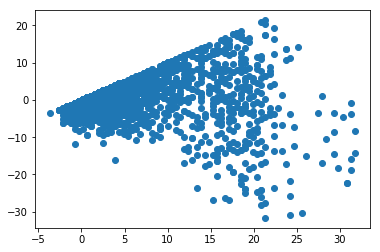

In [69]:
# Residuals
x_plot = plt.scatter(y_pred, (y_pred - y_test))

'''
Clearly, there is heteroscedasticty present in the data. There is uncaptured structure. 
We should try polynomial regression.
'''